In [18]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat
%matplotlib inline

import sklearn
from sklearn import metrics
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy import stats

import implicit
import random

from tqdm import tqdm


In [6]:
# loads in all artist names to compare against
with open("artists.txt" , 'r') as f:
    lines = f.readlines()
artist_names = [x.strip() for x in lines]

In [7]:
# loads in spotify similarity scores
with open("scores.txt", 'r') as f:
    lines = f.readlines()
read_in = [x.strip() for x in lines]

# scores stored in format: [seed artist id, similar artists id, score]
scores = []
for sims in read_in:
    broken = sims.split(" ")
    scores.append([int(broken[0]), int(broken[1]), broken[2]])


In [8]:
# loads in spotify popularity scores
with open('popularity.txt', 'r') as f:
    lines = f.readlines()
popularity = [int(x.strip()) for x in lines]

### Load in different Matricis

In [35]:
# original matrix with symmetry and identity
data = sparse.csr_matrix(sparse.load_npz('original.npz')[:])
print(data.shape)

(145963, 145963)


In [36]:
# matrix with identity but no symmetry
no_sym = sparse.csr_matrix(sparse.load_npz('no_sym.npz')[:])
print(no_sym.shape)

(145955, 145955)


In [37]:
# matrix with no identity or symmetry
clean = sparse.csr_matrix(sparse.load_npz('no_sym_no_self.npz')[:])
print(clean.shape)

(145955, 145955)


In [38]:
test_original = data[:50000, :50000]
test_sym = no_sym[:50000, :50000]
test_clean = clean[:50000, :50000]
print(test_original.shape)

(50000, 50000)


In [39]:
def make_train(sim, pct_test = 0.2):
    '''
    This function will take in the original artist-artist matrix and "mask" a percentage of the original similarities where a
    artist-artist interaction has taken place for use as a test set. The test set will contain all of the original similarities, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    sim - the original similarity matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of artist-artist interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original similarities. 
    
    '''
    # Make a copy of the original set
    test_set = sim.copy()
    # Store the test set as a binary preference matrix
    test_set[test_set !=0 ] = 1
    # Copy of original data to alter as training set
    training_set = sim.copy()
    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero()
    # Zip these pairs together of artist,artist index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    # Set the random seed to zero for reproducibility
    random.seed(0) 
    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))
    # Sample a random number of user-item pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples)
    # Get first artist row indices
    artist1_inds = [index[0] for index in samples] 
    # Get similar artist column indices
    artist2_inds = [index[1] for index in samples]
    # Assign all of the randomly chosen artist-artist pairs to zero
    training_set[artist1_inds, artist2_inds] = 0
    # Get rid of zeros in sparse array storage after update to save space
    training_set.eliminate_zeros()
    # Output the unique list of user rows that were altered  
    return training_set, test_set, list(set(artist1_inds))
    

In [40]:
product_train, product_test, product_artists_altered = make_train(test_original, pct_test = 0.2)
sym_train, sym_test_set, sym_altered = make_train(test_sym, pct_test = 0.2)
clean_train, clean_test_set, clean_altered = make_train(test_clean, pct_test = 0.2)
print("Training set: ", product_train.shape)
print("Test set: ", product_test.shape)

Training set:  (50000, 50000)
Test set:  (50000, 50000)


### Implicit ALS

In [59]:
# ALS using the Implicit Library
# Trains on the original set
alpha = 15
original_model = implicit.als.AlternatingLeastSquares(factors=25, regularization = 0.1, iterations = 50)
original_model.fit((product_train*alpha).astype('double'))
user_vecs = original_model.user_factors
item_vecs = original_model.item_factors

100%|██████████| 50.0/50 [00:25<00:00,  1.85it/s]


In [97]:
alpha = 15
sym_model = implicit.als.AlternatingLeastSquares(factors=32, regularization = 0.1, iterations=50)
sym_model.fit((no_sym*alpha).astype('double'))
sym_user_vecs = sym_model.user_factors
sym_item_vecs = sym_model.item_factors

100%|██████████| 50.0/50 [00:42<00:00,  1.14it/s]


In [42]:
# trains on set with no symmetry
alpha = 15
sym_model = implicit.als.AlternatingLeastSquares(factors=25, regularization = 0.1, iterations=50)
sym_model.fit((sym_train*alpha).astype('double'))
sym_user_vecs = sym_model.user_factors
sym_item_vecs = sym_model.item_factors

100%|██████████| 50.0/50 [00:22<00:00,  2.38it/s]


In [43]:
alpha = 15
clean_model = implicit.als.AlternatingLeastSquares(factors=25, regularization = 0.1, iterations=50)
clean_model.fit((clean_train*alpha).astype('double'))
clean_user_vecs = clean_model.user_factors
clean_item_vecs = clean_model.item_factors

100%|██████████| 50.0/50 [00:21<00:00,  2.40it/s]


### Evaluation

In [22]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    predictions: your prediction output
    test: the actual target result you are comparing to
    '''
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)
    
    

In [23]:
def mean_auc(training_set, altered_artists, predictions, test_set):
    '''
    This function will calculate the mean AUC by artist for any artist that had their artist-artist matrix altered. 
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each artist/artist pair as output from the implicit MF.
    These should be stored in a list, with artist vectors as item zero and item vectors as artist one. 
    
    altered_users - The indices of the users where at least one artist/artist pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    '''
    
    # An empty list to store the AUC for each artist that had an item removed from the training set
    store_auc = []
    # To store popular AUC scores
    popularity_auc = []
    # Get sum of item iteractions to find most popular
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1)
    item_vecs = predictions[1]
    # Iterate through each artist that had an item altered
    indx_to_remove = []
    for artist in tqdm(altered_artists):
        # Get the training set row
        training_row = training_set[artist,:].toarray().reshape(-1)
        # Find where the interaction had not yet occurred
        zero_inds = np.where(training_row == 0)
        # Get the predicted values based on our artist/item vectors
        artist_vec = predictions[0][artist,:]
        pred = artist_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this artist that originally had no iteraction
        actual = test_set[artist,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training
        # Get the item popularity for our chosen items
        pop = pop_items[zero_inds]
        # Calculate AUC for the given artist and store
        if (sum(pred) != 0):
            store_auc.append(auc_score(pred, actual))
            # Calculate AUC using most popular and score
            popularity_auc.append(auc_score(pop, actual))
        else:
            indx_to_remove.append(altered_artists.index(artist))

            
        
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc)), store_auc, indx_to_remove
    
    

### Evaluation for the different matrix

In [61]:
# evaluation for original set
altered, popular, auc_scores, og_remove= mean_auc(product_train, product_artists_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], clean_test_set)


100%|██████████| 30669/30669 [12:55<00:00, 39.54it/s]


In [98]:
# evaluation for set with no symmetry
sym_alt, sym_pop, sym_auc_scores, sym_remove = mean_auc(sym_train, sym_altered,
                    [sparse.csr_matrix(sym_user_vecs), sparse.csr_matrix(sym_item_vecs.T)], clean_test_set)

  0%|          | 40/24378 [00:01<11:58, 33.89it/s]


KeyboardInterrupt: 

In [63]:
#evaluation for the clean set
clean_alt, clean_pop, clean_auc_scores, clean_remove = mean_auc(clean_train, clean_altered,
                    [sparse.csr_matrix(clean_user_vecs), sparse.csr_matrix(clean_item_vecs.T)], clean_test_set)

100%|██████████| 24378/24378 [09:51<00:00, 41.20it/s]


### Graphing

In [64]:
def make_altered_set(altered_artists, to_remove):
    better_altered = np.delete(altered_artists, to_remove)
    pop_scores = []    
    for artist in better_altered:
        pop_scores.append(popularity[artist])
    return pop_scores

Original Altered Mean:  0.7645670496890002
No Symmetry Mean AUC:  0.924
Clean Mean AUC:  0.906


Text(0.5, 1.0, 'Clean Matrix')

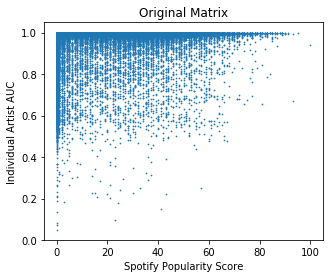

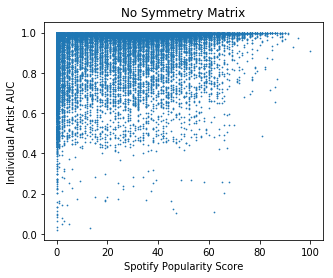

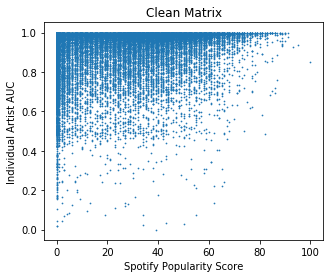

In [67]:
# Graph individual AUC vs Popularity scores

og_scores = make_altered_set(product_artists_altered.copy(), og_remove)
sym_scores = make_altered_set(sym_altered.copy(), sym_remove)
clean_scores = make_altered_set(clean_altered.copy(), clean_remove)

og_auc = auc_scores.copy()
sym_auc = sym_auc_scores.copy()
clean_auc = clean_auc_scores.copy()

x = np.nan_to_num(og_auc, 50)
print("Original Altered Mean: ", np.mean(x))
print("No Symmetry Mean AUC: ", sym_alt)
print("Clean Mean AUC: ", clean_alt)

plt.figure(1, figsize=(5,4))
plt.scatter(og_scores, og_auc, s=0.5)
plt.xlabel("Spotify Popularity Score")
plt.ylabel("Individual Artist AUC")
plt.title("Original Matrix")

plt.figure(2, figsize=(5,4))
plt.scatter(sym_scores, sym_auc, s=0.5)
plt.xlabel("Spotify Popularity Score")
plt.ylabel("Individual Artist AUC")
plt.title("No Symmetry Matrix")

plt.figure(3, figsize=(5,4))
plt.scatter(clean_scores, clean_auc, s=0.5)
plt.xlabel("Spotify Popularity Score")
plt.ylabel("Individual Artist AUC")
plt.title("Clean Matrix")


In [68]:
def get_r(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value


In [70]:
og_r = get_r(x, og_scores)
sym_r = get_r(sym_auc, sym_scores)
clean_r = get_r(clean_auc, clean_scores)

print("Original R_value: ", og_r)
print("Sym R_value: ", sym_r)
print("Clean R_value: ", clean_r)

Original R_value:  0.21359602942296899
Sym R_value:  0.24017349929452247
Clean R_value:  0.2419406041838753


In [145]:
oddity = 0
for score in clean_auc:
    if score > 0.95:
        oddity+=1
print(oddity/len(clean_auc))

0.6896566042436574


### Heavy Rotation Conversion
convert a users heavy rotation artists into a k-dim vector for use with model

In [99]:
#THIS IS BEING IMPLEMENTED IN THE 'Recommending Artists' NOTEBOOK

model = sym_model
test_user_vecs = model.user_factors
test_item_vecs = model.item_factors

print(test_item_vecs.shape)


#create an array of zeros that is the same length of item vecs
test_rotation = np.zeros(len(test_item_vecs))

#select 15 random indeces to be the heavy rotation artists
for i in range(0,15):
    indx = random.randint(0, len(test_rotation))
    test_rotation[indx] = 1

zero_indx = np.where(test_rotation == 0)
prediction = test_rotation.dot(test_item_vecs)

    
#possibly use this where artist_vec is the users selected heavy rotation artists
#pred = artist_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
# Get the training set row
#training_row = training_set[artist,:].toarray().reshape(-1)
# Find where the interaction had not yet occurred
#zero_inds = np.where(training_row == 0)


#COULD POSSIBLY USE THE 'SIMILAR ITEMS' METHOD FOR EACH ARTIST IN HEAVY ROTATION




(145955, 32)


### Nearest Neighbours
violates idea that test data has not been seen before
weighing data before spliting and masking data
#### need to correct this later

In [163]:
# create a copy of the test data and apply bm25 weighting to it
NN_test = test_data.copy()
NN_weighted = implicit.nearest_neighbours.bm25_weight(NN_test).tocsr()
train, test, altered = make_train(NN_weighted, pct_test = 0.2)

In [169]:
# create and fit the item-item model wih the weighted matrix
nn = implicit.nearest_neighbours.ItemItemRecommender()
nn.fit(train)
print(nn.similarity[18])


100%|██████████| 20000/20000 [00:00<00:00, 230403.73it/s]

  (0, 18)	795.2259745684746
  (0, 201)	99.40077860018184
  (0, 210)	81.95334782335235
  (0, 211)	114.25374866282642
  (0, 15889)	217.38260370940455
  (0, 16465)	86.08165331838173
  (0, 16472)	86.08165331838173
  (0, 16486)	80.41127453407408
  (0, 16487)	80.41127453407408
  (0, 16490)	99.40077860018184
  (0, 16491)	82.9478813991307
  (0, 16493)	80.1401999309094
  (0, 16496)	109.69243807619475
  (0, 16521)	86.08165331838173
  (0, 16526)	131.91541820011477
  (0, 16527)	156.0358900257143
  (0, 16528)	131.91541820011477
  (0, 16531)	114.25374866282642
  (0, 16534)	81.51323009715756
  (0, 16538)	156.0358900257143


In [150]:
def tims_rank_items(model, artist_id, artist_items):
    # calculate the relevance scores
    liked_vector = artist_items[artist_id]
    recommendations = liked_vector.dot(model.similarity)

    # remove items that are not in the selected_items
    best = sorted(zip(recommendations.indices, recommendations.data), key=lambda x: -x[1])
    ret = [rec for rec in best if rec[0] in selected_items]

    # returned items should be equal to input selected items
    for itemid in selected_items:
        if itemid not in recommendations.indices:
            ret.append((itemid, -1.0))
    return ret

In [161]:
def item_item_mean_auc(training_set, altered_artists, test_set):
    
    auc_bank = []
    for artist in altered_artists:
        # Get the training set row
        training_row = training_set[artist,:].toarray().reshape(-1)
        # Find where the interaction had not yet occurred
        zero_inds = np.where(training_row == 0)
        prediction = nn.rank_items(artist, training_set, training_row)
        print(prediction)
        # Select all ratings from the MF prediction for this artist that originally had no iteraction
        actual = test_set[artist,:].toarray()[0,zero_inds].reshape(-1) 
        print(len(actual))
        print(len(prediction))
        auc_bank.append(auc_score(prediction, actual))
    
        
    return float('%.3f'%np.mean(auc_bank))
        
        

In [162]:
item_item_mean_auc(train, altered, test)

[(0.0, -1.0), (0.0, -1.0), (3.485869891354217, -1.0), (0.0, -1.0), (3.208304611032282, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (3.46471138062, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (0.0, -1.0), (3.3532166707664905, -1.0), (3.095181269713808, -1.0), (3.4248215850788406, -1.0), (0.0, -1.0), (0.0, -1.0), (2.8304144553827992, -1.0), (3.370212014240683, -1.0), (3.208304611032282, -1.0), (3.0560448340978232, -1.0), (0.0, -1.0), (3.290313938408216, -1.0), (3.137515935529992, -1.0), (3.126603710643891, -1.0), (3.3532166707664905, -1.0), (3.4059718155217498, -1.0), (3.2211030770232085, -1.0), (0.0, -1.0), (0.0, -1.0), (3.1159164961964314, -1.0), (3.4059718155217498, -1.0), (3.208304611032282, -1.0), (0.0, -1.0), (3.38778357960554, -1.0), (0.0, -1.0), (0.0, -1.0), 

ValueError: Found input variables with inconsistent numbers of samples: [19970, 20000]